# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
#!unzip processed-celeba-small.zip

# Choose WGAN implementation or DCGAN implementation

In [2]:
WGAN = True
load_saved = True

In [3]:
data_dir = '/home/workspace/processed_celeba_small/celeba'

In [4]:
from typing import Tuple, Callable, Dict

import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Grayscale, Resize, Normalize, ToPILImage
from torchvision.io import read_image
from torchvision.datasets import ImageFolder


import tests

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module
import torch.optim as optim
from torch import autograd

from datetime import datetime
from workspace_utils import active_session


## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [6]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [Resize(size),
                  ToPILImage(),
                  ToTensor(),
                  Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [7]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.directory = directory
        self.extension = extension
        self.all_imgs = glob.glob1(self.directory,"*"+self.extension)
        self.total_imgs = sorted(self.all_imgs)
        self.transforms = transforms

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        num = len(glob.glob1(self.directory,"*"+self.extension))
        return num

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        img_path = os.path.join(".", self.directory, str(self.total_imgs[index]))
        image = read_image(img_path)
        if self.transforms:
            image = self.transforms(image)
        return image

In [8]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

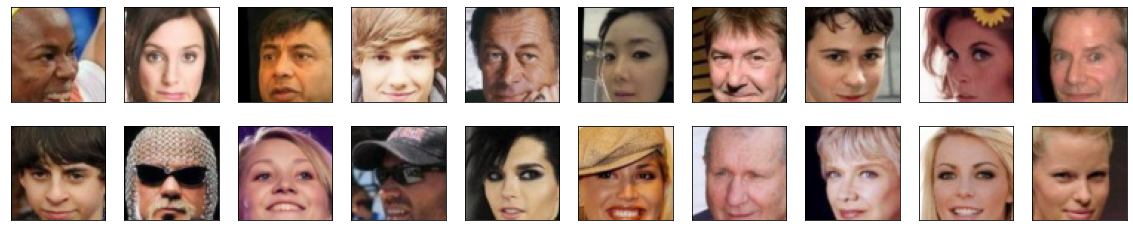

In [9]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    #print(idx)
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [11]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                       kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm and not WGAN:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)
    
conv_dim = 32
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        
        self.conv5 = conv(conv_dim*8, conv_dim*8, 4, stride=1)
        self.conv6 = conv(conv_dim*8, conv_dim*8, 4, stride=1)
        self.conv7 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)
        
        self.leakyrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.leakyrelu(self.conv1(x))
        x = self.leakyrelu(self.conv2(x))
        x = self.leakyrelu(self.conv3(x))
        x = self.dropout(x)
        x = self.leakyrelu(self.conv4(x))
        x = self.dropout(x)
        
        x = self.leakyrelu(self.conv5(x))
        x = self.dropout(x)
        x = self.leakyrelu(self.conv6(x))
        x = self.dropout(x)
        x = self.conv7(x)
        return x 


In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

tensor([[[[-0.0004]]]], grad_fn=<MkldnnConvolutionBackward>)
Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [13]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    if batch_norm and not WGAN:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        # TODO: instantiate the different layers
        self.conv_dim = conv_dim

        self.t_conv1 = deconv(latent_dim, conv_dim*16, 4, batch_norm=True)
        self.t_conv2 = deconv(conv_dim*16, conv_dim*8, 4, batch_norm=True)
        self.t_conv3 = deconv(conv_dim*8, conv_dim*4, 4, batch_norm=True)
        self.t_conv4 = deconv(conv_dim*4, conv_dim*2, 4, batch_norm=True)
        self.t_conv5 = deconv(conv_dim*2, conv_dim, 4, batch_norm=True)
        self.t_conv6 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.relu(self.t_conv1(x))
        x = self.relu(self.t_conv2(x))
        x = self.relu(self.t_conv3(x))
        x = self.relu(self.t_conv4(x))
        x = self.relu(self.t_conv5(x))
        x = self.tanh(self.t_conv6(x))
        return x

In [14]:
def init_weight(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0, 0.02)
        if m.bias is not None:
            if m.bias.data is not None:
                m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()

In [15]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [16]:



def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    if WGAN:
        lr = 0.00005
        g_optimizer = optim.RMSprop(generator.parameters(), lr)
        d_optimizer = optim.RMSprop(discriminator.parameters(), lr)
    else:
        lr = 0.0002
        beta1 = 0.5
        beta2 = 0.999
        g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
        d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [17]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss 
    
    if WGAN:
        loss = -fake_logits.mean().view(-1)
    else:
        noise = 0.3 + (np.random.rand() * 0.5)
        labels = torch.ones_like(fake_logits) - noise
        if torch.cuda.is_available():
            labels = labels.cuda()
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(fake_logits, labels)

    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [18]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss 

    if WGAN:
        loss = -(real_logits.mean() - fake_logits.mean())
    else:
        noise = 0.3 + (np.random.rand() * 0.5)
        labels_1 = torch.ones_like(real_logits) - noise
        labels_0 =  torch.zeros_like(fake_logits)
        if torch.cuda.is_available():
            labels_0 = labels_0.cuda()
            labels_1 = labels_1.cuda()
        criterion = nn.BCEWithLogitsLoss()
        d_loss = criterion(real_logits, labels_1)
        g_loss = criterion(fake_logits, labels_0)
        loss = d_loss + g_loss
        
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [19]:


def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    batch_size = real_samples.size(0)
    eps = torch.rand(batch_size, 1, 1, 1).to(real_samples.device)
    eps = eps.expand_as(real_samples)
    interpolation = eps * real_samples + (1 - eps) * fake_samples

    interp_logits = discriminator(interpolation)
    grad_outputs = torch.ones_like(interp_logits)

    gradients = autograd.grad(
        outputs=interp_logits,
        inputs=interpolation,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(batch_size, -1)
    grad_norm = gradients.norm(2, 1)
    return torch.mean((grad_norm - 1) ** 2)


## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [21]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 30

# number of images in each batch
batch_size = 64

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

In [23]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 200

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        num_workers=4)



In [24]:
discriminator.apply(init_weight)
generator.apply(init_weight)

if load_saved:
    generator.load_state_dict(torch.load('model_g.pt'))
    discriminator.load_state_dict(torch.load('model_d.pt'))


In [25]:
def generate_image(latent_dim):
    # generate latent vector z
    z = np.random.normal(loc = 0, scale = 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    if torch.cuda.is_available():
        z = z.cuda()
    g_images = generator(z)
    return g_images.detach()

In [26]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    fake_images = generate_image(latent_dim)
            
    # compute generator loss
    D_fake = discriminator(fake_images)
    g_loss = generator_loss(D_fake)
    g_loss.backward()
    
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
# TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    if torch.cuda.is_available():
        real_images = real_images.cuda()
            
    # pass real images to descriminator
    D_real = discriminator(real_images)
            
    ## Compute fake loss on discriminator
    # generate fake images with generator
    fake_images = generate_image(latent_dim)
            
    # pass fake images to descriminator
    D_fake = discriminator(fake_images)
            
    # compute fake loss of descrimintor
    d_loss = discriminator_loss(D_real, D_fake)
    
    if WGAN:
        gp = gradient_penalty(discriminator, real_images, fake_images)
        loss = d_loss + gp
    else:
        loss = d_loss
        gp = None

    loss.backward()
            
    return {'loss': loss, 'gp': gp}

# Load saved weight to continue training

# TRAINING

2022-04-03 11:07:24 | Epoch [1/30] | Batch 0/510 | d_loss: -3.4824 | g_loss: 22.9249
2022-04-03 11:08:04 | Epoch [1/30] | Batch 200/510 | d_loss: -5.5503 | g_loss: -2.6661
2022-04-03 11:08:44 | Epoch [1/30] | Batch 400/510 | d_loss: -4.0201 | g_loss: -5.0082


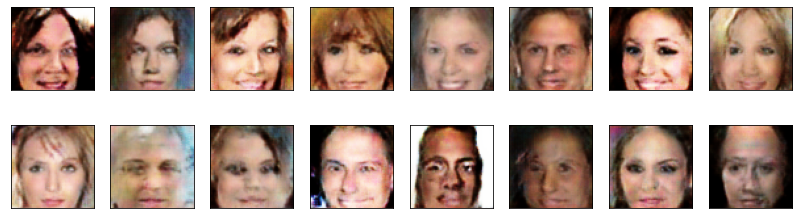

2022-04-03 11:09:07 | Epoch [2/30] | Batch 0/510 | d_loss: -3.7629 | g_loss: 2.9939
2022-04-03 11:09:47 | Epoch [2/30] | Batch 200/510 | d_loss: -3.7380 | g_loss: 1.5661
2022-04-03 11:10:27 | Epoch [2/30] | Batch 400/510 | d_loss: -3.6433 | g_loss: 0.3501
2022-04-03 11:10:50 | Epoch [3/30] | Batch 0/510 | d_loss: -3.4793 | g_loss: 7.9262
2022-04-03 11:11:30 | Epoch [3/30] | Batch 200/510 | d_loss: -2.9622 | g_loss: 0.9970
2022-04-03 11:12:10 | Epoch [3/30] | Batch 400/510 | d_loss: -3.7138 | g_loss: -0.4682
2022-04-03 11:12:33 | Epoch [4/30] | Batch 0/510 | d_loss: -5.2395 | g_loss: -4.0496
2022-04-03 11:13:13 | Epoch [4/30] | Batch 200/510 | d_loss: -4.0414 | g_loss: -2.2290
2022-04-03 11:13:53 | Epoch [4/30] | Batch 400/510 | d_loss: -5.1327 | g_loss: 0.5746
2022-04-03 11:14:16 | Epoch [5/30] | Batch 0/510 | d_loss: -1.3577 | g_loss: -1.6324
2022-04-03 11:14:56 | Epoch [5/30] | Batch 200/510 | d_loss: -5.3540 | g_loss: -4.5452
2022-04-03 11:15:36 | Epoch [5/30] | Batch 400/510 | d_lo

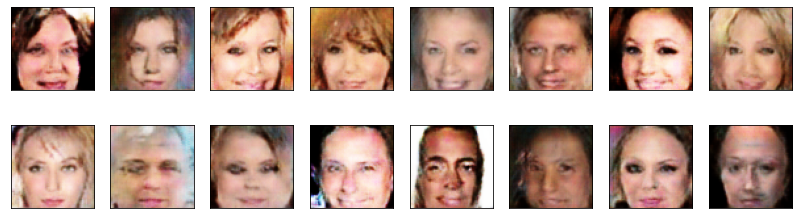

2022-04-03 11:17:42 | Epoch [7/30] | Batch 0/510 | d_loss: -1.7163 | g_loss: -4.8538
2022-04-03 11:18:23 | Epoch [7/30] | Batch 200/510 | d_loss: -3.0516 | g_loss: -6.3366
2022-04-03 11:19:03 | Epoch [7/30] | Batch 400/510 | d_loss: -3.0626 | g_loss: -0.0829
2022-04-03 11:19:25 | Epoch [8/30] | Batch 0/510 | d_loss: -3.2708 | g_loss: 0.0875
2022-04-03 11:20:06 | Epoch [8/30] | Batch 200/510 | d_loss: -5.1069 | g_loss: -3.4600
2022-04-03 11:20:46 | Epoch [8/30] | Batch 400/510 | d_loss: -4.2962 | g_loss: -3.4253
2022-04-03 11:21:08 | Epoch [9/30] | Batch 0/510 | d_loss: -4.2818 | g_loss: 2.9004
2022-04-03 11:21:48 | Epoch [9/30] | Batch 200/510 | d_loss: -2.1295 | g_loss: 0.1008
2022-04-03 11:22:29 | Epoch [9/30] | Batch 400/510 | d_loss: -4.7363 | g_loss: -1.0622
2022-04-03 11:22:51 | Epoch [10/30] | Batch 0/510 | d_loss: -3.5713 | g_loss: -4.6768
2022-04-03 11:23:31 | Epoch [10/30] | Batch 200/510 | d_loss: -5.4334 | g_loss: -3.1783
2022-04-03 11:24:11 | Epoch [10/30] | Batch 400/510 

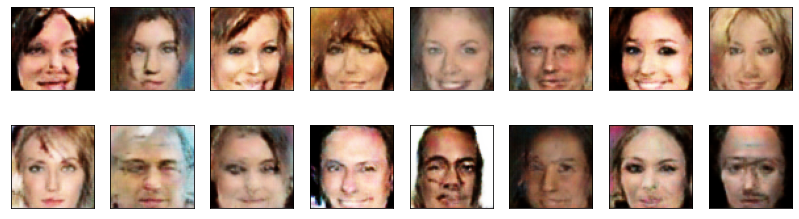

2022-04-03 11:26:18 | Epoch [12/30] | Batch 0/510 | d_loss: -3.8290 | g_loss: 7.2650
2022-04-03 11:26:58 | Epoch [12/30] | Batch 200/510 | d_loss: -2.6686 | g_loss: -1.1179
2022-04-03 11:27:39 | Epoch [12/30] | Batch 400/510 | d_loss: -2.7641 | g_loss: -3.3764
2022-04-03 11:28:01 | Epoch [13/30] | Batch 0/510 | d_loss: -2.5874 | g_loss: -7.5482
2022-04-03 11:28:41 | Epoch [13/30] | Batch 200/510 | d_loss: -5.2338 | g_loss: 0.3425
2022-04-03 11:29:21 | Epoch [13/30] | Batch 400/510 | d_loss: -1.8275 | g_loss: 2.6758
2022-04-03 11:29:44 | Epoch [14/30] | Batch 0/510 | d_loss: -3.6534 | g_loss: -4.1678
2022-04-03 11:30:24 | Epoch [14/30] | Batch 200/510 | d_loss: -3.5468 | g_loss: 0.2823
2022-04-03 11:31:04 | Epoch [14/30] | Batch 400/510 | d_loss: -2.5624 | g_loss: 1.2310
2022-04-03 11:31:27 | Epoch [15/30] | Batch 0/510 | d_loss: -4.9223 | g_loss: -1.9019
2022-04-03 11:32:07 | Epoch [15/30] | Batch 200/510 | d_loss: -4.5943 | g_loss: 4.9647
2022-04-03 11:32:47 | Epoch [15/30] | Batch 40

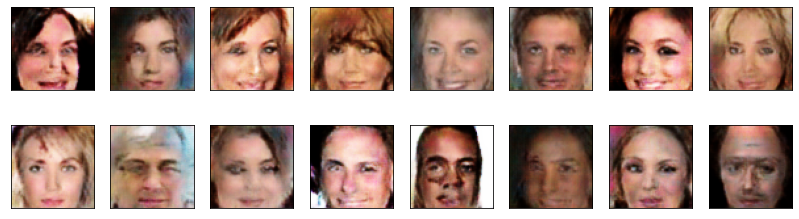

2022-04-03 11:34:53 | Epoch [17/30] | Batch 0/510 | d_loss: -3.1485 | g_loss: 2.8279
2022-04-03 11:35:34 | Epoch [17/30] | Batch 200/510 | d_loss: -2.3986 | g_loss: -1.2997
2022-04-03 11:36:14 | Epoch [17/30] | Batch 400/510 | d_loss: -3.7188 | g_loss: 0.8809
2022-04-03 11:36:36 | Epoch [18/30] | Batch 0/510 | d_loss: -3.2993 | g_loss: -0.0794
2022-04-03 11:37:16 | Epoch [18/30] | Batch 200/510 | d_loss: -2.0271 | g_loss: -3.0412
2022-04-03 11:37:57 | Epoch [18/30] | Batch 400/510 | d_loss: -4.2247 | g_loss: 4.5550
2022-04-03 11:38:19 | Epoch [19/30] | Batch 0/510 | d_loss: -1.9985 | g_loss: 5.9926
2022-04-03 11:38:59 | Epoch [19/30] | Batch 200/510 | d_loss: -2.0636 | g_loss: 2.2734
2022-04-03 11:39:40 | Epoch [19/30] | Batch 400/510 | d_loss: -3.7139 | g_loss: -4.0388
2022-04-03 11:40:02 | Epoch [20/30] | Batch 0/510 | d_loss: -4.1053 | g_loss: -4.7191
2022-04-03 11:40:42 | Epoch [20/30] | Batch 200/510 | d_loss: -2.1467 | g_loss: 0.6154
2022-04-03 11:41:22 | Epoch [20/30] | Batch 40

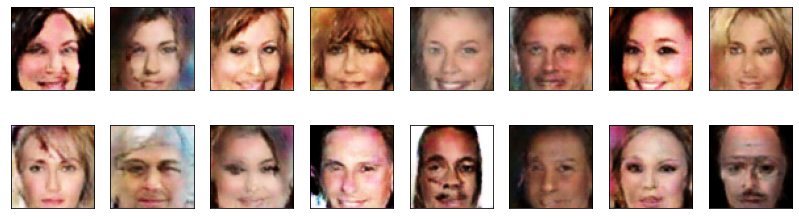

2022-04-03 11:43:29 | Epoch [22/30] | Batch 0/510 | d_loss: -2.8673 | g_loss: 1.6390
2022-04-03 11:44:09 | Epoch [22/30] | Batch 200/510 | d_loss: -4.8193 | g_loss: 2.3551
2022-04-03 11:44:49 | Epoch [22/30] | Batch 400/510 | d_loss: -3.3203 | g_loss: 1.7755
2022-04-03 11:45:12 | Epoch [23/30] | Batch 0/510 | d_loss: -3.3411 | g_loss: 2.3871
2022-04-03 11:45:52 | Epoch [23/30] | Batch 200/510 | d_loss: -0.3207 | g_loss: 0.0643
2022-04-03 11:46:32 | Epoch [23/30] | Batch 400/510 | d_loss: -2.5054 | g_loss: 0.4741
2022-04-03 11:46:54 | Epoch [24/30] | Batch 0/510 | d_loss: -2.5346 | g_loss: 3.5423
2022-04-03 11:47:35 | Epoch [24/30] | Batch 200/510 | d_loss: -2.7441 | g_loss: -1.5949
2022-04-03 11:48:15 | Epoch [24/30] | Batch 400/510 | d_loss: -4.1027 | g_loss: 0.6241
2022-04-03 11:48:37 | Epoch [25/30] | Batch 0/510 | d_loss: -3.6230 | g_loss: 0.3647
2022-04-03 11:49:18 | Epoch [25/30] | Batch 200/510 | d_loss: -2.9978 | g_loss: -4.5807
2022-04-03 11:49:58 | Epoch [25/30] | Batch 400/5

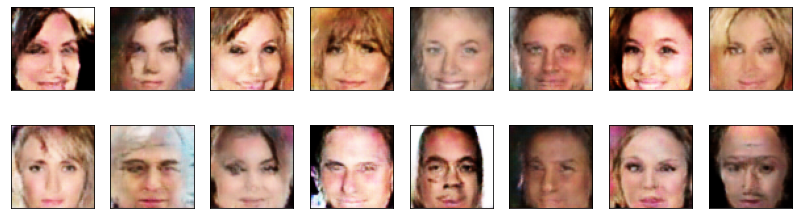

2022-04-03 11:52:04 | Epoch [27/30] | Batch 0/510 | d_loss: -1.5330 | g_loss: 0.7046
2022-04-03 11:52:44 | Epoch [27/30] | Batch 200/510 | d_loss: -3.2756 | g_loss: -4.2925
2022-04-03 11:53:25 | Epoch [27/30] | Batch 400/510 | d_loss: -3.6975 | g_loss: -2.3907
2022-04-03 11:53:47 | Epoch [28/30] | Batch 0/510 | d_loss: -4.1503 | g_loss: -2.7740
2022-04-03 11:54:27 | Epoch [28/30] | Batch 200/510 | d_loss: -4.6452 | g_loss: -4.0489
2022-04-03 11:55:08 | Epoch [28/30] | Batch 400/510 | d_loss: -3.5064 | g_loss: 3.4206
2022-04-03 11:55:30 | Epoch [29/30] | Batch 0/510 | d_loss: -2.7285 | g_loss: -0.2101
2022-04-03 11:56:10 | Epoch [29/30] | Batch 200/510 | d_loss: -3.6685 | g_loss: 1.8557
2022-04-03 11:56:51 | Epoch [29/30] | Batch 400/510 | d_loss: -3.9506 | g_loss: -3.0651
2022-04-03 11:57:13 | Epoch [30/30] | Batch 0/510 | d_loss: -4.1068 | g_loss: -1.2771
2022-04-03 11:57:53 | Epoch [30/30] | Batch 200/510 | d_loss: -3.8716 | g_loss: 2.0231
2022-04-03 11:58:34 | Epoch [30/30] | Batch 

In [27]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []

with active_session():
    for epoch in range(n_epochs):
        for batch_i, real_images in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            ####################################

            # TODO: implement the training strategy
            d_optimizer.zero_grad()
            d_loss = discriminator_step(batch_size,latent_dim, real_images)
            d_optimizer.step()

            if batch_i % 2 == 0: # train discriminator more than generator
                g_optimizer.zero_grad()
                g_loss = generator_step(batch_size, latent_dim)
                g_optimizer.step()

            ####################################
        
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                d = d_loss['loss'].item()
                g = g_loss['loss'].item()
                losses.append((d, g))
                # print discriminator and generator loss
                time = str(datetime.now()).split('.')[0]
                print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')

        # display images during training
        if epoch % 5== 0:
            generator.eval()
            generated_images = generator(fixed_latent_vector)
            display(generated_images)
            generator.train()
            model_name_d = 'model_d.pt'
            model_name_g = 'model_g.pt'
            torch.save(generator.state_dict(), model_name_g)
            torch.save(discriminator.state_dict(), model_name_d)

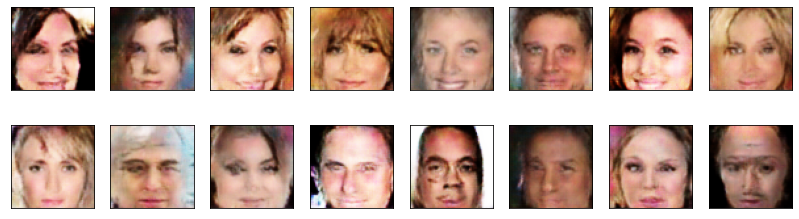

In [28]:
generator.eval()
generator_1 = Generator(latent_dim).to(device)
generator_1.load_state_dict(torch.load('model_g.pt'))
generated_images = generator_1(fixed_latent_vector)
display(generated_images)

### Training losses

Plot the training losses for the generator and discriminator.

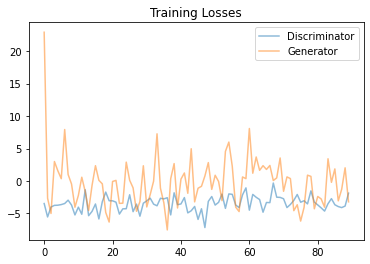

In [29]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:**

Please note that the content of the lessons or this project are not accessible to me. So I read about WGAN from other sources to be able to complete the project. 

I think the variety of the faces is good. But it is never enough, we can get more faces at different angles, with different accessories like glasses, caps and jewelry. The more features the network learn the better variety of faces are generated.

**WGAN model**:
 Some of the features of WGAN - https://arxiv.org/abs/1701.07875 were implemented.
 
1. I had first implemented DC-GAN, the generated faces were much clearer but I saw that the WGAN generated more variety of faces. Sometimes I saw the glasses being generated but I think there are very few training images with glasses for the network to learn that feature strongly.I am not statisfied with the clarity. I had to move ahead because of limitation of submission time and GPU hours available. I shall continue my experimentations in the future.

2. WGAN calls the discriminator as critic, I continued using "discriminator" to keep in line with the starter code. The critic is checking how much "fake" or "real" the input images are. It is minimizing the distance between the distribution of the data observed in the training dataset and the distribution observed in generated examples. More like a regression problem. Instead of a binary output now we have useful gradient information for updating the generator model. Hence we use RMSProp gradient descent with learning rate of 0.00005.

3. According to the continuous output value the loss is now changes to Wasserstein Loss where 

discriminator Loss = (mean of discriminator logits of real images) – (mean of discriminator logits of fake images)
Generator Loss = - (mean of discriminator logits of fake images)

4. The discriminator is trained twice everytime the generator is trained.

5. Gradient Penalty is also implemented to enforce a constraint such that the gradients of the critic’s output w.r.t the inputs to have unit norm. With GP batch_norm was disabled.

6. The model was saved periodically so that I can pick up the training whenever the connection is lost. This way I actually trained the WGAN-GP for 100 epochs.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.